### Tests find_thymio/goal

Image dimensions are 640 x 480
Map was not successfully computed.


NameError: name 'img_rect' is not defined

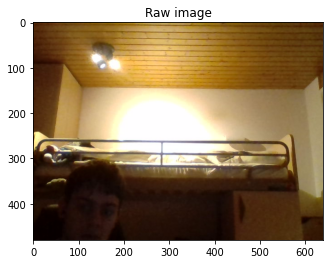

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import os

import sys  
#sys.path

sys.path.insert(1, 'src')
sys.path.insert(1, 'img')


import create_map
import locate_thymio_goal
import img_utils

from create_map import *
from locate_thymio_goal import *
from img_utils import *



filename = 'img/cam/img_normal.png'
img = cv2.imread(filename, cv2.IMREAD_COLOR)


################################################IMG_CORRECTION////////////////////////////////////////////////////

# read image
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Raw image")

# Initialize map
M, rect_width, rect_height, map, map_enlarged, success = create_map(img, 7, 11, verbose = True)
if success:
    plt.figure()
    plt.imshow(map_enlarged, origin = 'lower')
    plt.title("Map enlarged")
    plt.gca().invert_yaxis()
    plt.figure()
    plt.imshow(map, origin = 'lower')
    plt.title("Original Map")
    plt.gca().invert_yaxis()
    # We can now get the rectified image using the warp transform matrix
    # Separating the processes allow us to recalculate quickly the rectified map
    # without having to recalculate the warp transform matrix (assuming fixed camera).
    img_rect = get_rectified_img(img, M, rect_width, rect_height)
    plt.figure()
    plt.imshow(cv2.cvtColor(img_rect, cv2.COLOR_BGR2RGB))
    plt.title("Rectified image")
    plt.show()
else:
    print("Map was not successfully computed.")

[thymio_pose,thymio_found] = locate_thymio_camera(img_rect,'grid', [7,11])
[goal_coords,goal_found] = locate_goal_camera(img_rect,'grid', [7,11])


#hsv = cv2.cvtColor(img_rect, cv2.COLOR_BGR2HSV)
#hsv[270, 70]
#img[270,300]
print("Thymio_pose {}".format(thymio_pose))
print("Goal_coords {}".format(goal_coords))
if(thymio_found == 0):
    print("Thymio not found!")
if(goal_found == 0) :
    print("Goal not found!")


### Get speed function

In [25]:
	## Returns speed of the thymio in pixel/s.
    #  @param rect_img1/2    Rectified images used in the speed calculation
    #  @param dt             Elapsed time between the two images were taken
    #  @param speed_type     string variable that can take 'x_y' or 'front_side'
    #                        'x_y' the function will return the speed in x_y coordinates
    #                        'front_side' the function will return the speed in front and side coordinates
	#  @return speed         [total_speed, x_speed,y_speed] or [total_speed, front_speed,side_speed],
    #                        speed of the thymio in pixels/s.
def get_thymio_speed_camera(old_rect_img,new_rect_img,dt,speed_type):
    [thymio_pose1,thymio_found] = locate_thymio_camera(old_rect_img,'cartesian', [7,11])
    [thymio_pose2,thymio_found] = locate_thymio_camera(new_rect_img,'cartesian', [7,11])
    
    
    distance = math.sqrt(pow(thymio_pose2[0]-thymio_pose1[0],2) + pow(thymio_pose2[1]-thymio_pose1[1],2))
    total_speed = distance/dt
    #SPEED CALCULATION IN PIXEL/S
    if (speed_type == 'x_y'):
        x_speed = (thymio_pose2[0]-thymio_pose1[0])/dt
        y_speed = (thymio_pose2[1]-thymio_pose1[1])/dt
        
        speed =[total_speed,x_speed,y_speed]
        
    else:
        total_movement = [thymio_pose2[0]-thymio_pose1[0] , thymio_pose2[1]-thymio_pose1[1]]
        #u vecteur unitaire dans la direction du thymio
        u = [math.cos(thymio_pose1[2]), -math.sin(thymio_pose1[2])]
        front_movement = np.multiply(np.dot(total_movement,u),u)
        side_movement = total_movement-front_movement
        
        front_speed = math.sqrt(pow(front_movement[0],2) + pow(front_movement[1],2))/dt
        side_speed = math.sqrt(pow(side_movement[0],2) + pow(side_movement[1],2))/dt
        speed =[total_speed,front_speed,side_speed]
        
    return speed

### Speed and speed ratio measurements.

In [3]:

from MyThymio import*
thymio = MyThymio()


In [52]:
print(cv2.CAP_DSHOW)
IMAGE_WIDTH = 800
IMAGE_HEIGHT = 600
cam=cv2.VideoCapture(2+ cv2.CAP_DSHOW)
cam.set(3,IMAGE_WIDTH)
cam.set(4,IMAGE_HEIGHT)


img_taken = False
i = 0
while not img_taken:
    prev_img, img_taken = take_picture(cam)
    if(prev_img[0,0,0] == 230):
        img_taken = False
    print(i)
    i =i+1
    
print(prev_img)
plt.figure()
plt.imshow(cv2.cvtColor(prev_img, cv2.COLOR_BGR2RGB))
plt.title("Raw image")


700
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

KeyboardInterrupt: 

In [50]:
#IMPORTS
import camera
import MyThymio
from camera import*
import time


#th = connect_to_thymio(num_err = 20, verbose = True)
#MyThymio__init__(th, 0)

thymio.set_motor_speeds(0,0)

#INITIALIZATION
IMPUT_SPEED = 100

cam=cv2.VideoCapture(2+ cv2.CAP_DSHOW)
cam.set(3,IMAGE_WIDTH)
cam.set(4,IMAGE_HEIGHT)
img_taken = False
while not img_taken:
    prev_img, img_taken = take_picture(cam)
    if(prev_img[0,0,0] == 230):
        img_taken = False

print(prev_img)
    
plt.figure()
plt.imshow(cv2.cvtColor(prev_img, cv2.COLOR_BGR2RGB))
plt.title("Raw image")

t1 = time.time()
M, rect_width, rect_height, map, map_enlarged, success = create_map(prev_img, 7, 11, 0)

print(success)

plt.figure()
plt.imshow(cv2.cvtColor(prev_img, cv2.COLOR_BGR2RGB))
plt.title("Rectified image")

prev_rect_img = get_rectified_img(prev_img, M, rect_width, rect_height)

thymio.set_motor_speeds(100,100)

sleep(5)

new_img = take_picture(cam)
t2 = time.time()
new_rect_img = get_rectified_img(new_img, M, rect_width, rect_height)

thymio.set_motor_speeds(0,0)

dt = t2-t1

speed = get_thymio_speed(prev_rect_img,new_rect_img,dt,'x_y');
print("Thymio_speed {} pixels/s".format(speed))

#ratio speed(pixel)/speed(input)
ratio = speed/IMPUT_SPEED
print("Speed_ratio (speed(pixel)/speed(input)){}".format(ratio))


KeyboardInterrupt: 

### Kalman's Covariance Matrices:
Measurement of the typical covariance values to compute the Q and R matrices.

To find the total covariance for the position and the speed (covariance due to measurement AND state errors), we simply 
set a speed to the thymio and then take measurements of the speed and position of the robot from the camera. We take a lot of datapoints and then compute the covariance from those datapoints.

We also measure the position on a number of datapoints without setting any speed to the thymio. We can compute the covariance from those point to obtain the covariance of the position caused by the measurements only.
(If the values are too small or == 0 we can also approximate the position covariance by doing pos_standard_deviation = thymio_speed * sampling period.)


In [44]:

##Measurement covariance matrix (R)

MAP_WIDTH = 800
MAP_HEIGHT = 600
IMPUT_SPEED = 100
#time between each kalman call.
KALMAN_PERIOD = 0.05
#Replace with value found experimentally
SPPED_RATIO = 0.1

NB_DATAPOINTS = 100;
cam = init_camera(width = MAP_WIDTH, height = MAP_LENGTH)

#position (x,y) variance

thymio.set_motor_speeds(0,0)

thymio_x = []
thymio_y = []
for x in range(NB_DATAPOINTS):
    new_img, ret_val = take_picture(cam, video = 0) 
    M, rect_width, rect_height, map, map_enlarged, success = create_map(new_img, 7, 11, 0)
    new_img_rect = get_rectified_img(new_img, M, rect_width, rect_height)
    [new_thymio_pose,thymio_found] = locate_thymio_camera(new_img_rect,'cartesian', [7,11])
    thymio_x = np.append(thymio_x, new_thymio_pose[0])
    thymio_y = np.append(thymio_y, new_thymio_pose[1])
    sleep (0.05)


cov_xy_R = np.cov(thymio_x,thymio_y)

#other method for pos_cov: thymio_speed * sampling period =~ position error 

#Total pos and speed covariance computation (R+Q)

prev_img = take_picture(cam, video = 0)
M, rect_width, rect_height, map, map_enlarged, success = create_map(prev_img, 7, 11, 0)
prev_img_rect = get_rectified_img(prev_img, M, rect_width, rect_height)
prev_time = time.time()

[prev_thymio_pose,thymio_found] = locate_thymio_camera(prev_img,'cartesian', [7,11])

thymio.set_motor_speeds(IMPUT_SPEED,IMPUT_SPEED)

thymio_front_speed = []
thymio_side_speed = []
t = []
total_time = 0
time.sleep (KALMAN_PERIOD)

for x in range(NB_DATAPOINTS):
    new_img, ret_val = take_picture(cam, video = 0)
    new_time = time.time()
    M, rect_width, rect_height, map, map_enlarged, success = create_map(new_img, 7, 11, 0)
    new_img_rect = get_rectified_img(new_img, M, rect_width, rect_height)
    dt = new_time-prev_time
    
    [new_thymio_pose,thymio_found] = locate_thymio_camera(old_rect_img,'cartesian', [7,11])
    if(thymio_found):
        total_movement = [new_thymio_pose[0]-prev_thymio_pose[0] , new_thymio_pose[1]-prev_thymio_pose[1]]
        #u vecteur unitaire dans la direction du thymio
        u = [math.cos(prev_thymio_pose[2]), -math.sin(prev_thymio_pose[2])]
        front_movement = np.multiply(np.dot(total_movement,u),u)
        side_movement = total_movement-front_movement
        
        #eliminates the delta_t dependency in the movement 
        anticipated_front_movement = SPEED_RATIO*IMPUT_SPEED*dt
        anticipated_side_movement = 0
        front_error = anticipated_front_movement - front_movement
        side_error = anticipated_side_movement - side_movement  
        
        #speed_measurement
        speed = thymio.get_thymio_speed(new_img,prev_img,dt,'front_side')
        
        thymio_front_speed = np.append(thymio_front_speed, speed[1])
        thymio_side_speed = np.append(thymio_side_speed, speed[2])
        total_time = total_time + dt
        t = np.append(t, total_time)
    
    
    time.sleep (KALMAN_PERIOD)
    
    prev_thymio_pose = new_thymio_pose
    prev_img_rect = new_img_rect
    prev_time = new_time

cov_pos_front_side = np.cov(front_error,side_error)
cov_speed_front_side = np.cov(thymio_front_speed,thymio_side_speed)

print('valeurs constantes de la matrice de cov en mesure:')
print('covariance de la mesure en position {}\ncovariance totale en vitesse \n{}'.format(cov_xy_R,cov_speed_front_side))
print('covariance totale en position \n{}'.format(cov_pos_front_side))
print('la covariance totale de la vitesse et de la position est exprimée en fonction de l orientation du thymio, il faut maintenant l exprimer en fct des axes x et y')
#We then need to convert this values in x_y coordinates



NameError: name 'MAP_LENGTH' is not defined

The values for the total covariance are given in the Thymio's reference frame, we then need to turn them into x-y coordinates to be able to use them in our Kalman filter.

The function below returns the Q and R covariance matrices. It uses the angle of the thymio and the covariance values (const) computed with the above script, and returns the entire covariance matrices with x_y coordinates.

In [ ]:
#replace with values found in the previous script
COV_XY_R = 
COV_SPEED_FRONT_SIDE = 
COV_POS_FRONT_SIDE = 

#returns Q and R covariance matrices 
    #  @param angle          Angle of the thymio (rad)
	#  @return Q             (4x4) state moise covariance matrix 
    #  @return R             (4x4) measurement noise covariance matrix

def get_covariance_matrices(angle):
    
    Rotation = [[math.cos(angle),-math.sin(angle)],[math.sin(angle),math.cos(angle)]]
    cov_speed_xy = np.dot(np.dot(Rotation,COV_SPEED_FRONT_SIDE),np.transpose(Rotation))
    cov_pos_xy = np.dot(np.dot(Rotation,COV_POS_FRONT_SIDE),np.transpose(Rotation))

    #we assume that half the error observed is due to the measurements (the other half is generated by perturbations to the states)
    cov_speed_xy_R = np.multiply(cov_speed_xy,0.5)
    cov_speed_xy_Q = np.multiply(cov_speed_xy,0.5)

    R1 = np.append(cov_xy_R[0],[0,0])
    R2 = np.append(cov_xy_R[1],[0,0])
    R3 = np.append([0,0],cov_speed_xy_R[0])
    R4 = np.append([0,0],cov_speed_xy_R[1])
    R = [R1,R2,R3,R4]

    print('Matrice de covariance pour la mesure(R):\n{}\n(dans cet exemple angle = 30degrés)'.format(np.multiply(R,1)))

    #erreur de l'état>> que l'erreur de mesure=> cov_pos_Q =~ cov_pos_tot
    cov_xy_Q = cov_pos_xy

    Q1 = np.append(cov_xy_Q[0],[0,0])
    Q2 = np.append(cov_xy_Q[1],[0,0])
    Q3 = np.append([0,0],cov_speed_xy_Q[0])
    Q4 = np.append([0,0],cov_speed_xy_Q[1])
    Q = [Q1,Q2,Q3,Q4]
    print('Matrice de covariance de l état(Q):\n{}\n(dans cet exemple angle = 30degrés)'.format(np.multiply(Q,1)))
    
    return Q,R

### Tests

In [ ]:
a = [1,2]
b = [2,-1]

c = [a[0]-b[0],a[1]-b[1]]
np.dot(a,b)
d = np.multiply(a,np.dot(a,b))
print(d)

print(np.cov(a,b))

In [ ]:

old_img = cv2.imread('img/speed_test3.png', cv2.IMREAD_COLOR)
old_rect_img = get_rectified_img(old_img, M, rect_width, rect_height)
plt.figure()
plt.imshow(cv2.cvtColor(old_rect_img, cv2.COLOR_BGR2RGB))
plt.title("Pos1")

new_img = cv2.imread('img/speed_test1.png', cv2.IMREAD_COLOR)
new_rect_img = get_rectified_img(new_img, M, rect_width, rect_height)
plt.figure()
plt.imshow(cv2.cvtColor(new_rect_img, cv2.COLOR_BGR2RGB))
plt.title("Pos2")

dt = 1

get_thymio_speed_camera(old_rect_img,new_rect_img,dt,'front_side')

In [ ]:
A =[[1,3],[2,3]]
print(A)

B = [[2,1],[1,8]]

C1 = np.append(A[0],[0,0])
C2 = np.append(A[1],[0,0])
C = [C1,C2]

print(C)

D = np.multiply(C,1)
print('D{} \n A{}'.format(D,A))
print('la covariance en vitesse est exprimée en fonction de l orientation du thymio, il faut maintenant lexprimer en fct des axes x et y')

In [ ]:
##Measurement covariance matrix (R)
import random

#position (x,y) variance

#Replace with value found experimentally
SPEED_RATIO = 0.05
NB_DATAPOINTS = 50
IMPUT_SPEED = 100
KALMAN_PERIOD = 0.05

thymio_x = []
thymio_y = []
for x in range(10):
    thymio_x = np.append(thymio_x, 10+random.randrange(0, 100)/1000)
    thymio_y = np.append(thymio_y, 10+random.randrange(0, 100)/1000)


cov_xy_R = np.cov(thymio_x,thymio_y)

#other method for pos_cov: thymio_speed * sampling period =~ position error 

#speed_variance

prev_time = time.time()

prev_thymio_pose = [10,10,0]

thymio_front_speed = []
thymio_side_speed = []
t = []
total_time = 0
time.sleep (KALMAN_PERIOD)

for x in range(NB_DATAPOINTS):
    
    new_time = time.time()
    dt = new_time-prev_time
    
    new_thymio_pose = [prev_thymio_pose[0]+SPEED_RATIO*IMPUT_SPEED*dt+ random.randrange(0, 100)/100, prev_thymio_pose[1]+ random.randrange(0, 100)/200,prev_thymio_pose[2]+ random.randrange(0, 100)/10000]
    if(thymio_found):
        total_movement = [new_thymio_pose[0]-prev_thymio_pose[0] , new_thymio_pose[1]-prev_thymio_pose[1]]
        #u vecteur unitaire dans la direction du thymio
        u = [math.cos(prev_thymio_pose[2]), -math.sin(prev_thymio_pose[2])]
        front_movement = np.multiply(np.dot(total_movement,u),u)
        side_movement = total_movement-front_movement
        
        #eliminates the delta_t dependency in the movement 
        anticipated_front_movement = SPEED_RATIO*IMPUT_SPEED*dt
        anticipated_side_movement = 0
        front_error = anticipated_front_movement - front_movement
        side_error = anticipated_side_movement - side_movement    
        
        
        #speed_measurement
        distance = math.sqrt(pow(new_thymio_pose[0]-prev_thymio_pose[0],2) + pow(new_thymio_pose[1]-prev_thymio_pose[1],2))
        total_speed = distance/dt
        front_speed = math.sqrt(pow(front_movement[0],2) + pow(front_movement[1],2))/dt
        side_speed = math.sqrt(pow(side_movement[0],2) + pow(side_movement[1],2))/dt
        
        speed =[total_speed,front_speed,side_speed]
        
        thymio_front_speed = np.append(thymio_front_speed, speed[1])
        thymio_side_speed = np.append(thymio_side_speed, speed[2])
        total_time = total_time + dt
        t = np.append(t, total_time)
    
    
    time.sleep (KALMAN_PERIOD)
    
    prev_thymio_pose = new_thymio_pose
    prev_time = new_time

cov_pos_front_side = np.cov(front_error,side_error)
cov_speed_front_side = np.cov(thymio_front_speed,thymio_side_speed)

print('valeurs constantes de la matrice de cov en mesure:')
print('covariance de la mesure en position\n{}\ncovariance totale en vitesse \n{}'.format(cov_xy_R,cov_speed_front_side))
print('covariance totale en position \n{}'.format(cov_pos_front_side))
print('la covariance totale de la vitesse et de la position est exprimée en fonction de l orientation du thymio, il faut maintenant l exprimer en fct des axes x et y')
#We then need to convert this values in x_y coordinates

#pos,angle = get_last_position(th)
angle = 0 #example

Rotation = [[math.cos(angle),-math.sin(angle)],[math.sin(angle),math.cos(angle)]]
cov_speed_xy = np.dot(np.dot(Rotation,cov_speed_front_side),np.transpose(Rotation))
cov_pos_xy = np.dot(np.dot(Rotation,cov_pos_front_side),np.transpose(Rotation))

#we assume that half the error observed is due to the measurements (the other half is generated by perturbations to the states)
cov_speed_xy_R = np.multiply(cov_speed_xy,0.5)
cov_speed_xy_Q = np.multiply(cov_speed_xy,0.5)

R1 = np.append(cov_xy_R[0],[0,0])
R2 = np.append(cov_xy_R[1],[0,0])
R3 = np.append([0,0],cov_speed_xy_R[0])
R4 = np.append([0,0],cov_speed_xy_R[1])
R = [R1,R2,R3,R4]

print('\nMatrice de covariance pour la mesure(R):\n{}\n(dans cet exemple angle = 0degrés)'.format(np.multiply(R,1)))

#erreur de l'état>> que l'erreur de mesure=> cov_pos_Q =~ cov_pos_tot
cov_xy_Q = cov_pos_xy

Q1 = np.append(cov_xy_Q[0],[0,0])
Q2 = np.append(cov_xy_Q[1],[0,0])
Q3 = np.append([0,0],cov_speed_xy_Q[0])
Q4 = np.append([0,0],cov_speed_xy_Q[1])
Q = [Q1,Q2,Q3,Q4]
 
print('matrice de covariance de l état(Q):\n{}\n(dans cet exemple angle = 0degrés)'.format(np.multiply(Q,1)))

In [22]:
def returnCameraIndexes():
    # checks the first 10 indexes.
    index = 0
    arr = []
    i = 10
    while i > 0:
        cap = cv2.VideoCapture(index)
        if cap.read()[0]:
            arr.append(index)
            cap.release()
        index += 1
        i -= 1
    return arr

In [23]:
print(returnCameraIndexes())

[0, 2]
